In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rio

# Save country data

In [2]:
# load country data from Natural Earth
country_data = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_map_units.shp')

In [3]:
# load country data from Natural Earth
country_data = gpd.read_file('../data/country_data/10m_cultural/ne_10m_admin_0_map_units.shp')

ISO_codes = country_data.ISO_A3_EH.value_counts()
country_data.loc[country_data['ISO_A3_EH'].isin(ISO_codes[ISO_codes==1].index),'SOVEREIGNT'] = country_data.loc[country_data['ISO_A3_EH'].isin(ISO_codes[ISO_codes==1].index),'NAME']

# replace ISO_A3_EH values of -99 with the ADM0_ISO value
country_data.loc[country_data['ISO_A3_EH']=='-99','ISO_A3_EH'] = country_data.loc[country_data['ISO_A3_EH']=='-99','ADM0_ISO']

# group countries by their ISO_A3_EH code
# use ISO_A#_EH because it aggregates countries such that 99.9% of the surface area of land has an ISO ID
country_ISO_df = country_data[country_data['ISO_A3_EH'] !='-99'].sort_values('HOMEPART',ascending=False).dissolve(by='ISO_A3_EH')['SOVEREIGNT']
country_ISO_df.name= 'NAME'

# save file to csv so RECCAP regions and Pan et al. regions can be added to it
country_ISO_df.sort_values().to_csv('../data/country_data/country_iso.csv')

# Add RECCAP and Pan et al. data

In [35]:
# load data with RECCAP regions
country_ISO_df_w_RECCAP = pd.read_csv('../data/country_data/country_iso_RECCAP.csv',index_col=0)

# load the data from Extended Data Table 2 from Pan et al. (2024)
pan_data = pd.read_excel('../data/biomass/pan_et_al_2024/RDS-2023-0051/Data/Pan_etal_2024/Summary_Tables_Global_Forest_Inventory_1990-2020.xlsx', sheet_name='Table 2 Stock', skiprows=3,index_col=0).iloc[:36,:6]

# drop rows that are missing all data and the subtotal row
pan_data = pan_data.dropna(how='all',axis=0).drop(index='Subtotal').reset_index(names='region')

# replace left and right parentheses with empty string and remove any digits at the end of the string
pan_data['region'] = pan_data['region'].str.replace(r'\(','').str.replace(r'\d+$', '', regex=True)

# add columns for Pan et al. regions based on the definitions in Extended Data Table 2 in Pan et al. 2024
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME=='Canada','Pan region'] = 'Canada (managed part)'

# define countries with the metadata based on ISO_A3_EH and remove 
ISO_country_data = country_data[country_data['ISO_A3_EH'] !='-99'].sort_values('HOMEPART',ascending=False).dissolve(by='ISO_A3_EH')

# Boreal Europe is defined as Norway, Sweden, Finland, and Svalbard Is.
bor_eu = ['Norway','Sweden','Finland','Svalbard Is.']

# Other Europe is defined as Ukraine, Belarus, Armenia, Georgia, Azerbaijan, and Turkey
other_eu = ['Ukraine','Belarus','Armenia','Georgia','Azerbaijan','Turkey']

# Other countries in the temperate zone are defined as Mongolia and Kazakhstan
other_countries = ['Mongolia','Kazakhstan']

# Other South Asia is defined as Afghanistan, Pakistan, Nepal, Bhutan, Bangladesh, and Sri Lanka
other_south_asia = ['Afghanistan', 'Pakistan', 'Nepal', 'Bhutan', 'Bangladesh', 'Sri Lanka']

# Southeast Asia is defined as Indonesia, Malaysia, Philippines, Cambodia, Thailand, Myanmar, Laos, Vietnam, Papua New Guinea, Timor-Leste, Singapore, and Brunei
sea = ['Indonesia','Malaysia','Philippines','Cambodia','Thailand','Myanmar','Laos','Vietnam','Papua New Guinea','Timor-Leste','Singapore','Brunei']

# Temperate Europe is defined as all European countries except Russia, Boreal Europe, and Other Europe
temp_eu = ISO_country_data.loc[(ISO_country_data.CONTINENT=='Europe') & ~ISO_country_data.NAME.isin(['Russia'] + bor_eu+ other_eu)].index.unique()

# Africa is defined as all African countries
africa = ISO_country_data[ISO_country_data.CONTINENT=='Africa'].index.unique()

# Central America is defined as all countries in Central America and the Caribbean except Mexico
south_america = ISO_country_data[ISO_country_data.CONTINENT=='South America'].index.unique()

# Set the Pan region for each country
central_america = ISO_country_data[ISO_country_data.SUBREGION.isin(['Central America','Caribbean']) & (ISO_country_data.NAME!='Mexico')].index.unique()
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(bor_eu),'Pan region'] = 'Europe (boreal)'
country_ISO_df_w_RECCAP.loc[temp_eu,'Pan region'] = 'Europe (temperate)'
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(other_eu),'Pan region'] = 'Other Europe'
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.str.contains('Korea'),'Pan region'] = 'Korea'
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(other_countries),'Pan region'] = 'Other countries'
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(other_south_asia),'Pan region'] = 'Other South Asia'
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(sea),'Pan region'] = 'Southeast Asia'
country_ISO_df_w_RECCAP.loc[africa,'Pan region'] = 'Africa'
country_ISO_df_w_RECCAP.loc[central_america,'Pan region'] = 'Central America'
country_ISO_df_w_RECCAP.loc[south_america,'Pan region'] = 'South America'

# add the Pan region for countries that are in both the country data and Pan et al. data
overlapping = country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(pan_data.region.unique())]
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME.isin(overlapping.NAME),'Pan region'] = overlapping['NAME']

# set the Pan region for USA
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME == 'United States of America','Pan region'] = 'United States'

# set the Pan region for Taiwan
country_ISO_df_w_RECCAP.loc[country_ISO_df_w_RECCAP.NAME == 'Taiwan','Pan region'] = 'China'

/home/ymbaron/data/projects/land_sink_partitioning/.venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Add FAO data

In [36]:
# load FAO country definitions
fao_country_data = pd.read_csv('../data/country_data/FAOSTAT_country_definitions.csv')
fao_country_data = fao_country_data.set_index('ISO3 Code')['Country']
fao_country_data.name = 'FAO_name'

# define final geodataframe with country data - remove data without ISO code, groupby ISO code and take name, continent and geometry
final_country_df = country_data[country_data['ISO_A3_EH'] !='-99'].sort_values('HOMEPART',ascending=False).dissolve(by='ISO_A3_EH')[['SOVEREIGNT','CONTINENT','geometry']]

# change names of columns
final_country_df.columns = ['NAME','CONTINENT','geometry']

# merge final_country_df with country_ISO_df_w_RECCAP
final_country_df = final_country_df.merge(country_ISO_df_w_RECCAP.drop(columns='NAME'), left_index=True, right_index=True, how='left')

# merge final_country_df with fao_country_data
final_country_df = final_country_df.merge(fao_country_data, left_index=True, right_index=True, how='left')

final_country_df.to_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')

/tmp/ipykernel_1229907/1662814792.py:18: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_country_df.to_file('../data/country_data/country_data_w_RECCAP_Pan_FAO.shp')


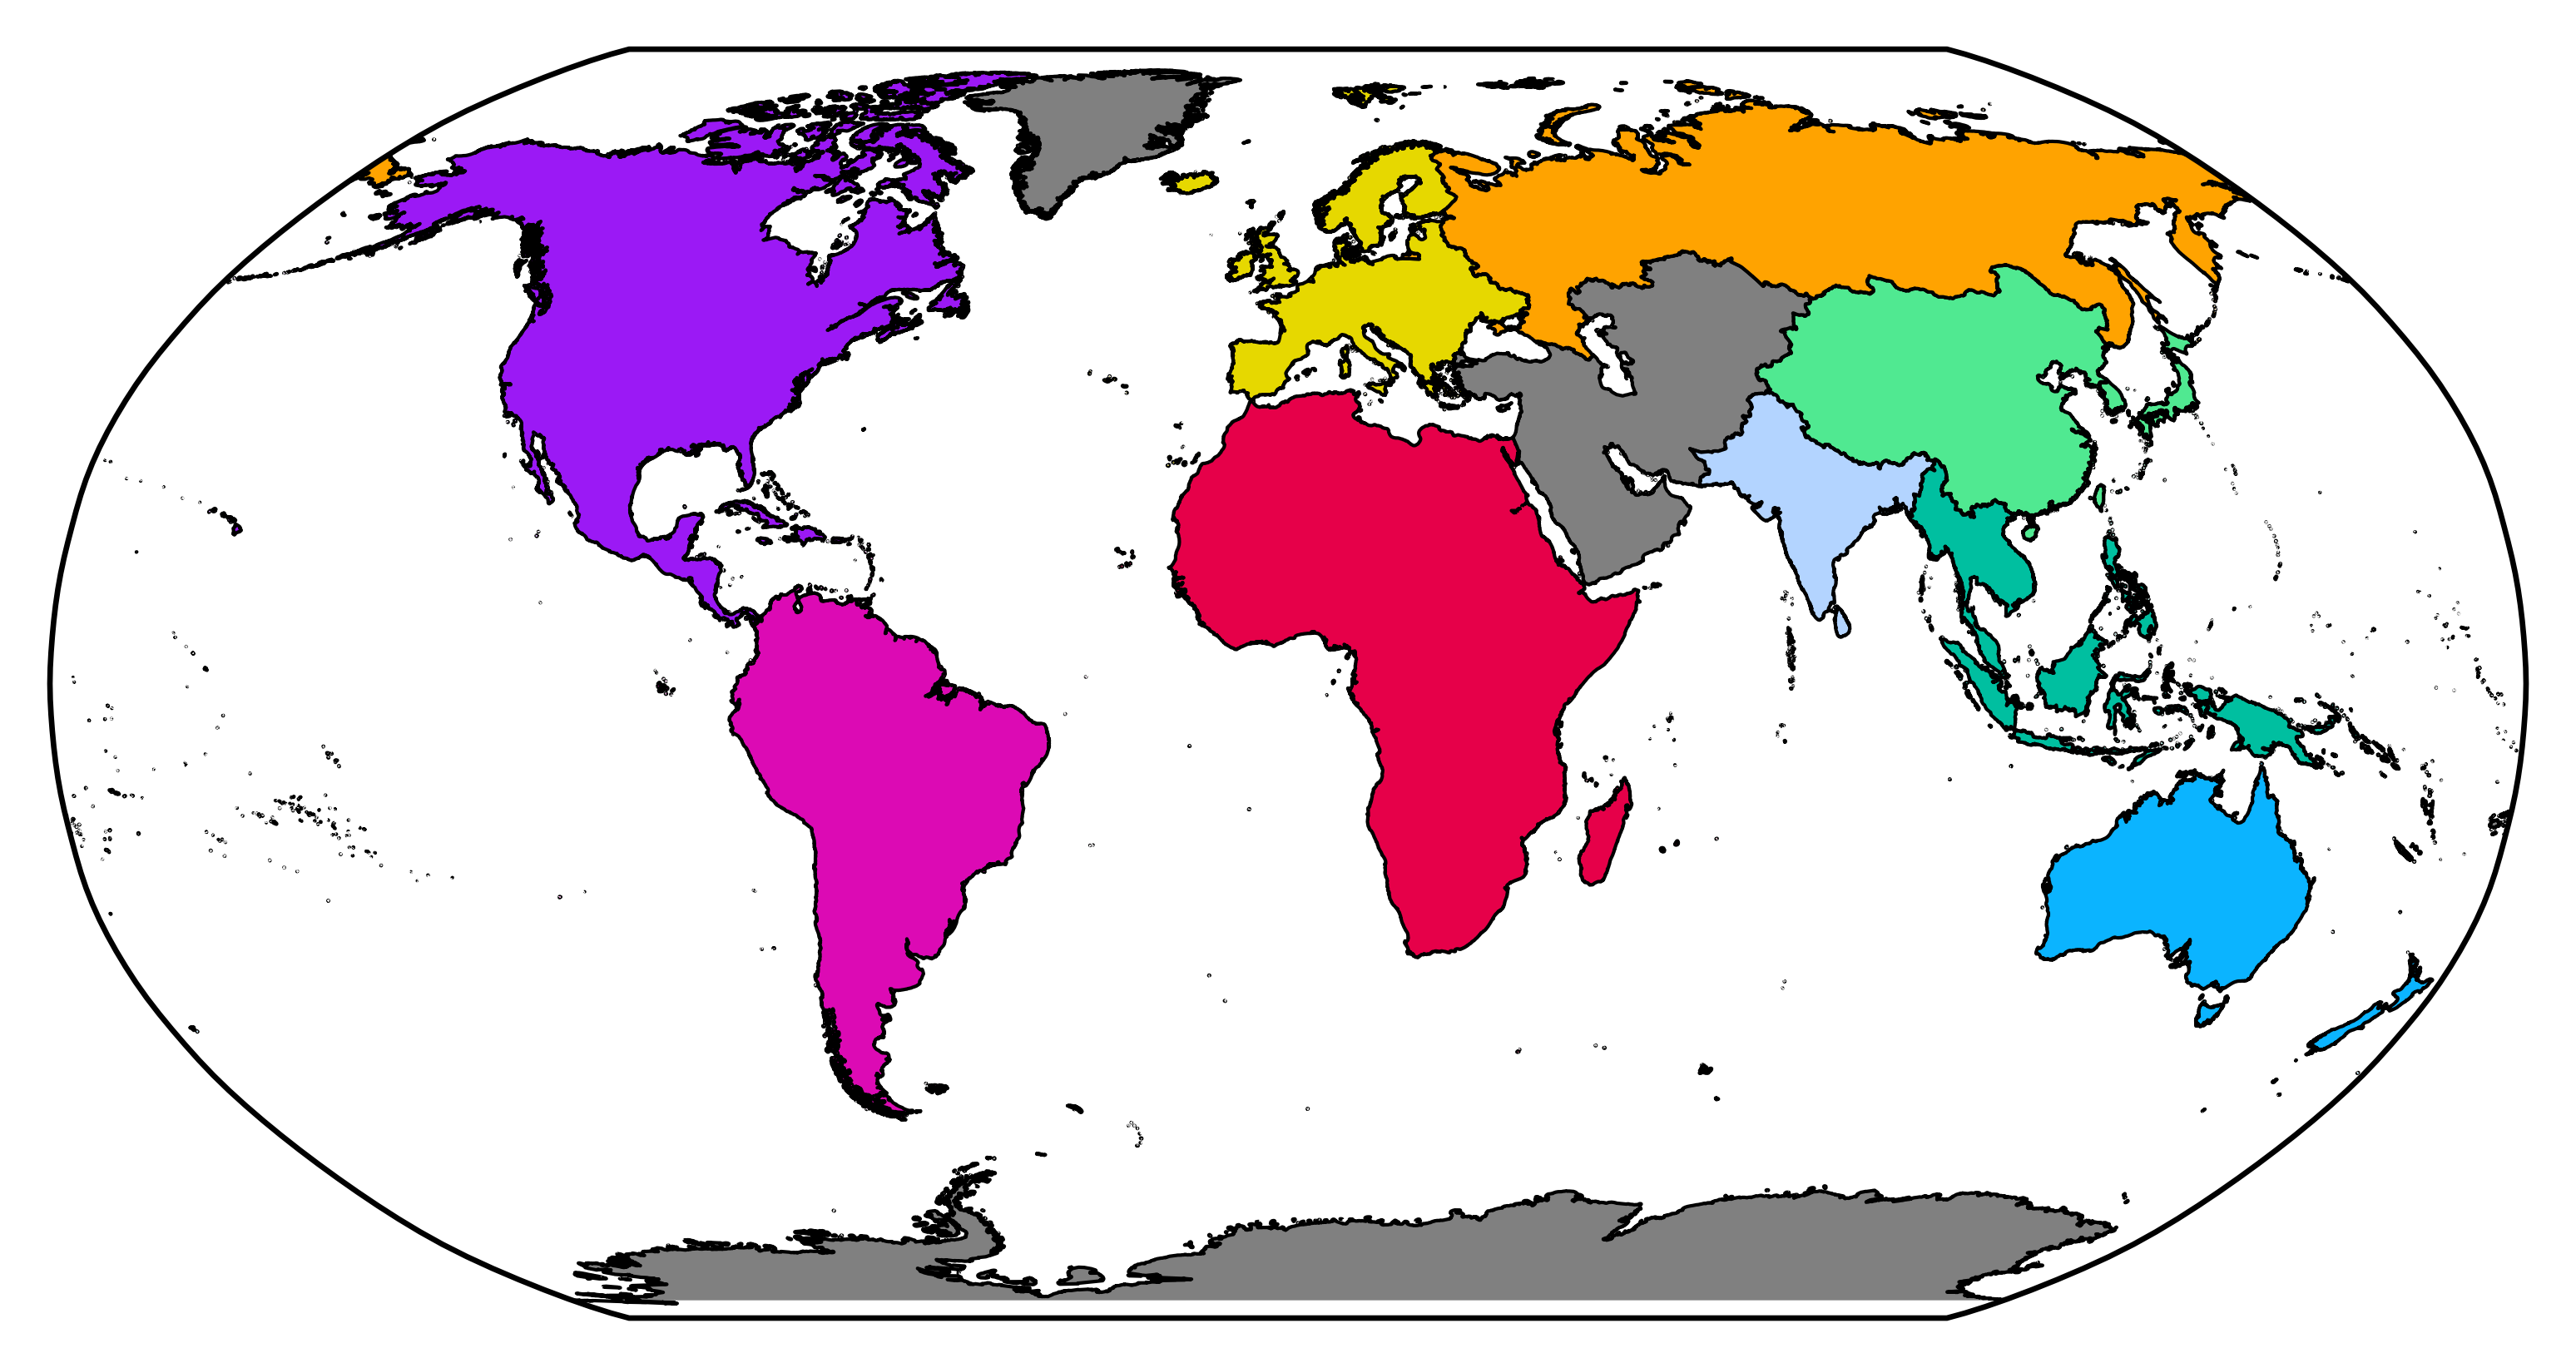

In [33]:
# plot RECCAP regions to make sure it looks OK

RECCAP = final_country_df.dissolve(by='RECCAP region')
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
fig = plt.figure(dpi=600)
ax = fig.add_subplot(1,1,1,projection=ccrs.Robinson())
cs = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5",'grey', "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

for i,c in enumerate(cs):
        RECCAP.iloc[i:i+1].plot(facecolor=c,edgecolor='k',lw=0.5,ax=ax,transform=ccrs.PlateCarree())

# WWF ecoregions

In [5]:
# Define the names of the aggregated biome names
agg_biome_name_dict = {1 : 'Tropical & Subtropical Forests'
,2 : 'Tropical & Subtropical Forests'
,3 : 'Tropical & Subtropical Forests'
,4 : 'Temperate Forests'
,5 : 'Temperate Forests'
,6 : 'Boreal Forests/Taiga'
,7 : 'Tropical & Subtropical Grasslands, Savannas & Shrublands'
,8 : 'Temperate Grasslands, Savannas & Shrublands'
,9 : 'Flooded Grasslands & Savannas'
,10 : 'Temperate Grasslands, Savannas & Shrublands'
,11 : 'Tundra'
,12 : 'Mediterranean Forests, Woodlands & Scrub'
,13 : 'Deserts & Xeric Shrublands'
,14 : 'Mangroves'}

# Load ecoregions
ecoregions = gpd.read_file('../data/regions_data/WWF_ecoregions/wwf_terr_ecos.shp')

# create a dataframe with the biome names
# biome_names = pd.DataFrame([biome_name_dict.keys(),biome_name_dict.values()],index=['BIOME','BIOME_NAME']).T
agg_biome_names = pd.DataFrame([agg_biome_name_dict.keys(),agg_biome_name_dict.values()],index=['BIOME','BIOME_NAME']).T

# merge the biome names with the ecoregions
ecoregions = ecoregions.merge(agg_biome_names,on='BIOME',how='left')

# remove ecoregions without biome name
ecoregions = ecoregions[~ecoregions.BIOME_NAME.isna()]

# group the ecoregions by biome name and realm
wwf_ecoregions = ecoregions.dissolve(by=['BIOME_NAME','REALM']).reset_index()

# add an id to the ecoregions
wwf_ecoregions['id']=range(wwf_ecoregions.shape[0])

# save aggregated WWF ecoregions
wwf_ecoregions[['BIOME_NAME','geometry','id']].to_file('../results/00_preprocessing/agg_wwf_ecoregions.shp')